In [1]:

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import transforms
import numpy as np
import torch
from torch import nn
import os
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
from torch.nn import DataParallel
from torch.utils.data import Subset
import shutil
from codes.helpers import FocalLoss

2024-03-23 13:24:18.108188: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 13:24:18.109836: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 13:24:18.142441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 13:24:18.994097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Hyperparameters
# We can adjust the learning_rate here to improve the model performance, scheduler is used to reduce the learning rate at specific epochs
# The batch size can be adjusted based on the available memory
# If apply_augmentations is set to True, the model will apply augmentations to the images to improve the model performance
load_saved_model = False
generator_name_to_load = "generator.pth"
discriminator_name_to_load = "discriminator.pth"

apply_augmentations = True
training_epoch = 400
batch_size = 8
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.00005
scheduler = 1

device = "cuda"
logdir = "logs/"
resultdir = "logs/results_transformer/"

if os.path.exists(resultdir):
    shutil.rmtree(resultdir)
os.makedirs(resultdir)

In [3]:
class Fashion_Data(Dataset):
    def __init__(self, folder_train, folder_ground_truth, augmentation=None):
        self.folder_train = folder_train
        self.folder_ground_truth = folder_ground_truth
        self.transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()]) if augmentation is None \
                            else transforms.Compose([augmentation, transforms.Resize((512, 512)), transforms.ToTensor()]) 
        
        self.filenames = [f for f in os.listdir(folder_train) if os.path.isfile(os.path.join(folder_train, f))]
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_name_train = os.path.join(self.folder_train, self.filenames[idx])
        img_name_gt = os.path.join(self.folder_ground_truth, self.filenames[idx])

        img_train = Image.open(img_name_train).convert('RGB')
        img_gt = Image.open(img_name_gt).convert('RGB')

        if self.transform:
            img_train = self.transform(img_train)
            img_gt = self.transform(img_gt)

        return img_train, img_gt

Train size: 1106, Test size: 123
Shape of the images: torch.Size([3, 512, 512])


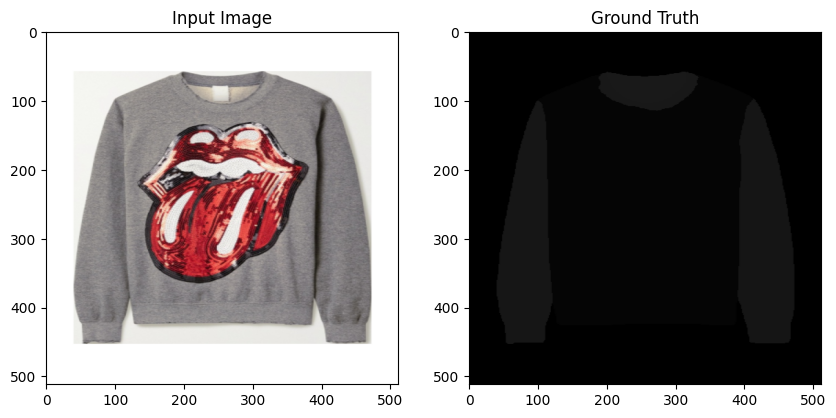

In [4]:
train_folder = "dataset/upper/cloth_align"
gt_folder = "dataset/upper/cloth_align_parse-bytedance"

full_set = Fashion_Data(train_folder, gt_folder)

# We want to validate model using fraction dataset (how many percent parts of the dataset will be used)
fraction_size = 0.08
# Calculate sizes
full_dataset_size = len(full_set)
subset_size = int(fraction_size * full_dataset_size)  # Total size of the subset to use

# Create indices for the subset
subset_indices = torch.randperm(full_dataset_size)[:subset_size].tolist()

# Create a subset based on the indices
subset = Subset(full_set, subset_indices)

# Now, calculate train and test sizes for the subset
train_size = int(0.9 * len(subset))  # 90% of the subset size
test_size = len(subset) - train_size  # The rest for testing

# Split the subset into train and test
train_dataset, test_dataset = random_split(subset, [train_size, test_size], generator=torch.Generator().manual_seed(42))


dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

print(f'Train size: {len(train_dataset)}, Test size: {len(test_dataset)}')

# Get the example image from the train dataset
first_image_train, first_image_gt = train_dataset[10]
print(f'Shape of the images: {first_image_train.shape}')

# Plot the first image side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(first_image_train.permute(1, 2, 0))
axes[0].set_title('Input Image')
axes[1].imshow(first_image_gt.permute(1, 2, 0))
axes[1].set_title('Ground Truth')


plt.show()

In [5]:
# The diagram is provided to understand the architecture
from architecture.discriminator import Discriminator
from architecture.generator import Generator


discriminator = Discriminator(in_channels=3).to(device)
generator = Generator(in_channels=3).to(device)
optimizer_disc = optim.Adam(discriminator.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_gen = optim.Adam(generator.parameters(), lr=learning_rate, weight_decay=weight_decay)
writer = SummaryWriter(log_dir=logdir)

In [6]:
# The code to make sure the model input and output are correct, we can test the first batch to fed into the network
data = next(iter(dataloader_train))

test_data = data[0]
output_test = generator(test_data.to(device))
print(output_test.shape)

torch.Size([8, 3, 512, 512])


In [7]:
from tqdm import tqdm
import torch.cuda.amp as amp
from codes.helpers import save_image

class Engine(object):
    def __init__(self, discriminator, generator, optimizer_disc, optimizer_gen, device, ema=None):
        # Initialize the Engine with the model, optimizer, and the device it's running on.
        self.discriminator = discriminator
        self.generator = generator
        self.optimizer_disc = optimizer_disc
        self.optimizer_gen = optimizer_gen
        self.device = device
        # Current epoch of training.
        self.cur_epoch = 0
        # Number of iterations the training has run.
        self.cur_iter = 0
        # The best validation epoch, used to track the epoch with the best validation performance.
        self.bestval_epoch = 0
        # Lists to track the training and validation losses.
        self.train_loss_disc = []
        self.train_loss_gen = []
        self.val_loss_disc = []
        self.val_loss_gen = []
        # Gradient scalers for mixed precision training
        self.g_scaler = amp.GradScaler()
        self.d_scaler = amp.GradScaler()
        # Criterion for calculating loss. Here, it's Mean Squared Error Loss for regression tasks.
        self.criterion_bce = torch.nn.BCEWithLogitsLoss()
        self.criterion_l1 = torch.nn.L1Loss()
        self.l1_lambda = 100

    """ Block to begin training """
    def train(self, dataloader_train):
        self.discriminator.train()
        self.generator.train()
        
        disc_loss_epoch = 0.
        gen_loss_epoch = 0.
        num_batches = 0
        
        # Train loop
        # tqdm is used to display the training progress for each epoch.
        pbar = tqdm(dataloader_train, desc='Train Epoch {}'.format(self.cur_epoch))
        
        # X is image, Y is target image
        for idx, (x, y) in enumerate(pbar):
            x, y = x.to(self.device, dtype=torch.float32), y.to(self.device, dtype=torch.float32)
            with torch.cuda.amp.autocast():
                y_fake = generator(x)
                D_real = discriminator(x, y)
                D_fake = discriminator(x, y_fake.detach())
                D_real_loss = self.criterion_bce(D_real, torch.ones_like(D_real))
                D_fake_loss = self.criterion_bce(D_fake, torch.zeros_like(D_fake))
                D_loss = (D_real_loss + D_fake_loss) / 2
            
            self.optimizer_disc.zero_grad()
            self.d_scaler.scale(D_loss).backward()
            self.d_scaler.step(self.optimizer_disc)
            self.d_scaler.update()
            
            with torch.cuda.amp.autocast():
                D_fake = discriminator(x, y_fake)
                G_fake_loss = self.criterion_bce(D_fake, torch.ones_like(D_fake))
                L1 = self.criterion_l1(y_fake, y) * self.l1_lambda
                G_loss = G_fake_loss + L1
            
            self.optimizer_gen.zero_grad()
            self.g_scaler.scale(G_loss).backward()
            self.g_scaler.step(self.optimizer_gen)
            self.g_scaler.update()
            
            num_batches += 1
            disc_loss_epoch += float(D_loss.item())
            gen_loss_epoch += float(G_loss.item())
            pbar.set_description("D-Loss: {:.4f}, G-Loss: {:.4f}".format(D_loss.item(), G_loss.item()))
            
        pbar.close()
        avg_disc_loss = disc_loss_epoch / num_batches
        avg_gen_loss = gen_loss_epoch / num_batches
        self.train_loss_disc.append(avg_disc_loss)
        self.train_loss_gen.append(avg_gen_loss)

        self.cur_epoch += 1
        pbar.set_description("Epoch: {}, Avg D-Lose: {:.4f}, Avg G-Lose: {:.4f}".format(self.cur_epoch, avg_disc_loss, avg_gen_loss))
        
    def test(self, dataloader_test):
        self.discriminator.eval()
        self.generator.eval()
        disc_loss_epoch = 0.
        gen_loss_epoch = 0.
        num_batches = 0
        
        # Ensure the results directory exists
        epoch_result_dir = os.path.join(resultdir, str(self.cur_epoch))
        os.makedirs(epoch_result_dir, exist_ok=True)
        
        with torch.no_grad():
            pbar = tqdm(dataloader_test, desc='Test Epoch {}'.format(self.cur_epoch))
            for idx, (x, y) in enumerate(pbar):
                x, y = x.to(self.device, dtype=torch.float32), y.to(self.device, dtype=torch.float32)
                
                y_fake = self.generator(x)
                D_real = self.discriminator(x, y)
                D_fake = self.discriminator(x, y_fake)
                
                D_real_loss = self.criterion_bce(D_real, torch.ones_like(D_real))
                D_fake_loss = self.criterion_bce(D_fake, torch.zeros_like(D_fake))
                D_loss = (D_real_loss + D_fake_loss) / 2
                G_loss = self.criterion_bce(D_fake, torch.ones_like(D_fake)) + self.criterion_l1(y_fake, y) * self.l1_lambda
                
                disc_loss_epoch += D_loss.item()
                gen_loss_epoch += G_loss.item()
                num_batches += 1

                # Optionally save generated images for visual inspection
                for j, gen_image in enumerate(y_fake):
                    save_image(gen_image, os.path.join(epoch_result_dir, f"generated_{idx}_{j}.png"))
                
                pbar.set_description(f"Test D-Loss: {D_loss.item():.4f}, Test G-Loss: {G_loss.item():.4f}")
            
        avg_disc_loss = disc_loss_epoch / num_batches
        avg_gen_loss = gen_loss_epoch / num_batches
        self.val_loss_disc.append(avg_disc_loss)
        self.val_loss_gen.append(avg_gen_loss)
        
        print(f"Test Epoch: {self.cur_epoch}, Avg D-Loss: {avg_disc_loss:.4f}, Avg G-Loss: {avg_gen_loss:.4f}")


In [8]:
trainer = Engine(discriminator, generator, optimizer_disc, optimizer_gen, device, ema=None)

# Load the saved model if load_saved_model is set to True
if load_saved_model:
	discriminator.load_state_dict(torch.load(f'logs/{discriminator_name_to_load}'))
	generator.load_state_dict(torch.load(f'logs/{generator_name_to_load}'))
 
# Count the total number of trainable parameters
model_parameters1 = filter(lambda p: p.requires_grad, discriminator.parameters())
model_parameters2 = filter(lambda p: p.requires_grad, generator.parameters())
params = sum([np.prod(p.size()) for p in model_parameters1]) + sum([np.prod(p.size()) for p in model_parameters2])
print ('======Total trainable parameters: ', params)

for epoch in range(trainer.cur_epoch, training_epoch):
	trainer.train(dataloader_train)

	# Test the model every 20 epochs and save it to logs folder
	if (epoch) % 10 == 0:
		trainer.test(dataloader_test)
		torch.save(discriminator.state_dict(), os.path.join('logs', discriminator_name_to_load))
		torch.save(generator.state_dict(), os.path.join('logs', generator_name_to_load))


======Total trainable parameters:  57183236


Train Epoch 0:   0%|          | 0/139 [00:00<?, ?it/s]

Test D-Loss: 0.9696, Test G-Loss: 10.5226: 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]


Test Epoch: 1, Avg D-Loss: 0.9746, Avg G-Loss: 6.6270


D-Loss: 0.4620, G-Loss: 4.7309:  47%|████▋     | 66/139 [00:07<00:08,  8.40it/s]


KeyboardInterrupt: 